In [32]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString
from scipy.spatial import cKDTree


In [33]:

CUDA = True  # or False depending on your preference
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"

Data Preparation

In [34]:
df = pd.read_csv('data/node_features.csv')

# Extract features (remove coordinates and fatalities)
features = df.select_dtypes(include=np.number).drop(columns=['Latitude', 'Longitude', 'Fatalities'])
scaler = StandardScaler()
x = torch.tensor(scaler.fit_transform(features), dtype=torch.float)

# Use raw fatalities as regression target
y = torch.tensor(np.log(df['Fatalities']).values, dtype=torch.float)

KeyError: "['Fatalities'] not found in axis"

In [ ]:

road_gdf = gpd.read_file("data/singapore_road_network.gpkg", layer="edges")

## Build road graph from LineStrings
G = nx.Graph()
for geom in road_gdf.geometry:
    if isinstance(geom, LineString):
        coords = list(geom.coords)
        for start, end in zip(coords[:-1], coords[1:]):
            G.add_edge(start, end)

# Fix shape of road nodes
road_nodes = np.array([list(node) for node in G.nodes])
tree = cKDTree(road_nodes)

# Snap accident nodes to nearest road node
accident_coords = df[['Longitude', 'Latitude']].values
_, indices = tree.query(accident_coords)
snapped_nodes = road_nodes[indices]

# Assign unique node indices
unique_nodes, node_indices = np.unique(snapped_nodes, axis=0, return_inverse=True)
coord_to_index = {tuple(coord): i for i, coord in enumerate(unique_nodes)}

# Build edge_index from graph
edges = []
for u, v in G.edges:
    if u in coord_to_index and v in coord_to_index:
        u_idx = coord_to_index[u]
        v_idx = coord_to_index[v]
        edges.append([u_idx, v_idx])
        edges.append([v_idx, u_idx])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

In [ ]:
# Train/val/test split
idx = np.arange(len(y))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

train_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

In [ ]:
# Create graph data object
data = Data(x=x, edge_index=edge_index, y=y,
            train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

print(data)

Data(x=[108, 61], edge_index=[2, 2], y=[108], train_mask=[108], val_mask=[108], test_mask=[108])


GCN Model 

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 1)  # Output is scalar for regression

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return x.squeeze()  # Output shape: [num_nodes]


In [ ]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out[mask].detach().cpu().numpy()
    truth = data.y[mask].detach().cpu().numpy()
    rmse = root_mean_squared_error(truth, pred)
    r2 = r2_score(truth, pred)
    return rmse, r2, pred, truth


In [ ]:
model = GCN(in_channels=x.size(1), hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_losses, val_rmses, val_r2s = [], [], []
epochs = 200

for epoch in range(epochs):
    loss = train(model, optimizer, data)
    train_losses.append(loss)

    val_rmse, val_r2, _, _ = evaluate(model, data, data.val_mask)
    val_rmses.append(val_rmse)
    val_r2s.append(val_r2)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss={loss:.4f}, Val RMSE={val_rmse:.4f}, R2={val_r2:.4f}")


Epoch 0: Loss=8.2766, Val RMSE=2.2863, R2=-41.7523
Epoch 10: Loss=1.0227, Val RMSE=1.0753, R2=-8.4564
Epoch 20: Loss=0.3258, Val RMSE=0.8392, R2=-4.7602
Epoch 30: Loss=0.2965, Val RMSE=0.7962, R2=-4.1843
Epoch 40: Loss=0.2668, Val RMSE=0.7434, R2=-3.5198
Epoch 50: Loss=0.1895, Val RMSE=0.6963, R2=-2.9650
Epoch 60: Loss=0.1628, Val RMSE=0.6707, R2=-2.6791
Epoch 70: Loss=0.1147, Val RMSE=0.6723, R2=-2.6968
Epoch 80: Loss=0.1009, Val RMSE=0.6390, R2=-2.3393
Epoch 90: Loss=0.1479, Val RMSE=0.6525, R2=-2.4826
Epoch 100: Loss=0.0921, Val RMSE=0.6153, R2=-2.0968
Epoch 110: Loss=0.1032, Val RMSE=0.6048, R2=-1.9922
Epoch 120: Loss=0.1018, Val RMSE=0.5986, R2=-1.9307
Epoch 130: Loss=0.0873, Val RMSE=0.5725, R2=-1.6804
Epoch 140: Loss=0.1119, Val RMSE=0.5519, R2=-1.4912
Epoch 150: Loss=0.0721, Val RMSE=0.5670, R2=-1.6291
Epoch 160: Loss=0.0773, Val RMSE=0.5408, R2=-1.3917
Epoch 170: Loss=0.0827, Val RMSE=0.5289, R2=-1.2880
Epoch 180: Loss=0.0651, Val RMSE=0.5337, R2=-1.3299
Epoch 190: Loss=0.0792

Performance Visualisation

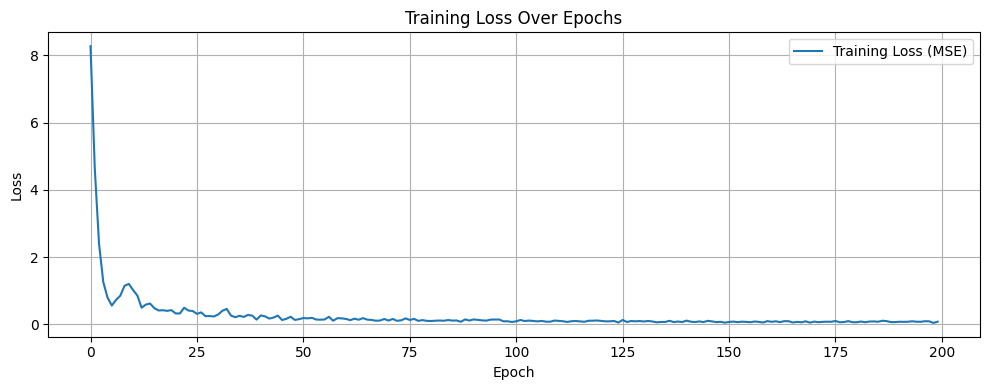

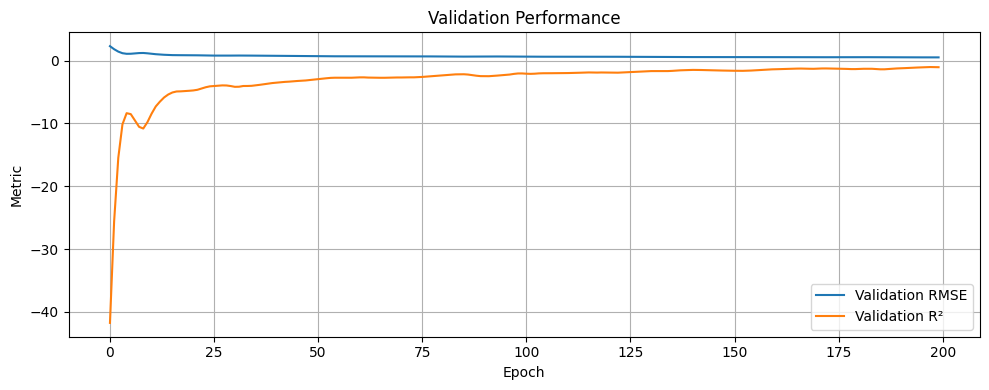

In [ ]:
# Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Training Loss (MSE)")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Validation RMSE and R2 Curve
plt.figure(figsize=(10, 4))
plt.plot(val_rmses, label="Validation RMSE")
plt.plot(val_r2s, label="Validation R²")
plt.title("Validation Performance")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Evaluation on Test Set


Final Test RMSE: 1.1022
Final Test R² Score: -16.0930


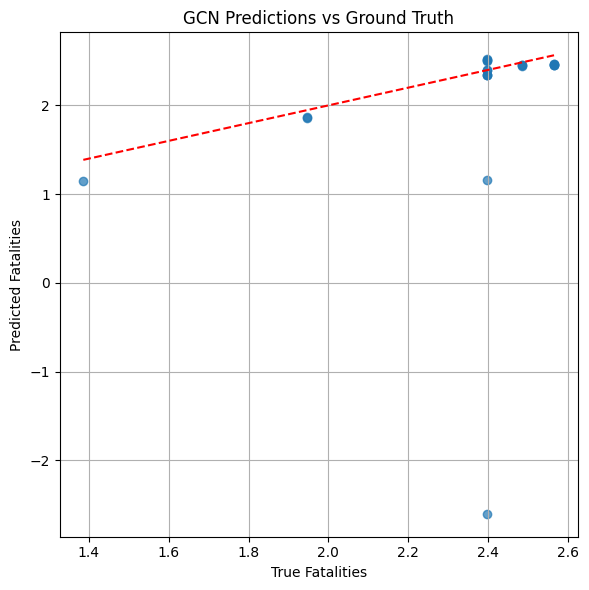

In [ ]:
test_rmse, test_r2, preds, truths = evaluate(model, data, data.test_mask)

print(f"\nFinal Test RMSE: {test_rmse:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

# Optional: Scatter plot for predicted vs true fatalities
plt.figure(figsize=(6, 6))
plt.scatter(truths, preds, alpha=0.7)
plt.plot([min(truths), max(truths)], [min(truths), max(truths)], 'r--')
plt.xlabel("True Fatalities")
plt.ylabel("Predicted Fatalities")
plt.title("GCN Predictions vs Ground Truth")
plt.grid(True)
plt.tight_layout()
plt.show()
